### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 8.25 s, sys: 1.85 s, total: 10.1 s
Wall time: 18min 3s


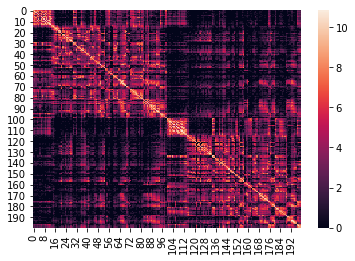

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 3s, sys: 863 ms, total: 1min 4s
Wall time: 9min 41s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.61 s, sys: 68.8 ms, total: 1.68 s
Wall time: 1.67 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [19]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [20]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 19s, sys: 2.97 s, total: 1min 22s
Wall time: 27min 16s


In [21]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

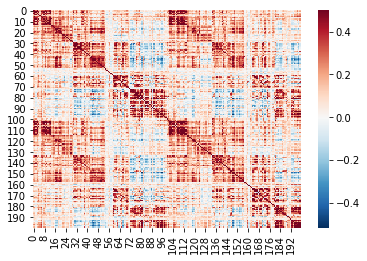

In [23]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

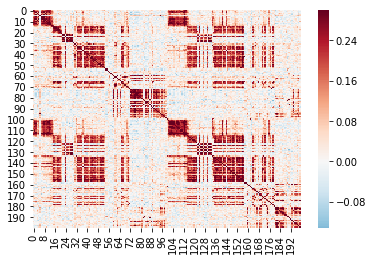

In [24]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [25]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [26]:
# corrs_list

In [27]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [28]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [29]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [30]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

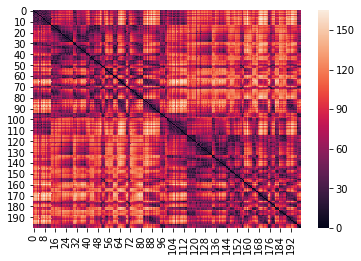

In [31]:
sns.heatmap(distance)

## Communicability

In [32]:
# intact sc

In [33]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 6.57 s, sys: 115 ms, total: 6.69 s
Wall time: 6.72 s


In [34]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [35]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [36]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 87.1 ms, sys: 221 ms, total: 308 ms
Wall time: 306 ms


In [43]:
# lesion sc

In [38]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 45.5 s, sys: 485 ms, total: 46 s
Wall time: 46.1 s


## BETWEEN NTWX

In [593]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = (np.mean(lh_ntwx_to_lh_vis) + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2 + np.mean(rh_ntwx_to_rh_vis))#/4
    mean_ntwx_to_sommot_sc = (np.mean(lh_ntwx_to_lh_sommot) + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2 + np.mean(rh_ntwx_to_rh_sommot))#/4
    mean_ntwx_to_dorsattn_sc = (np.mean(lh_ntwx_to_lh_dorsattn) + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2 + np.mean(rh_ntwx_to_rh_dorsattn))#/4
    mean_ntwx_to_ventattn_sc = (np.mean(lh_ntwx_to_lh_ventattn) + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2 + np.mean(rh_ntwx_to_rh_ventattn))#/4
    mean_ntwx_to_limbic_sc = (np.mean(lh_ntwx_to_lh_limbic) + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2 + np.mean(rh_ntwx_to_rh_limbic))#/4
    mean_ntwx_to_fpn_sc = (np.mean(lh_ntwx_to_lh_fpn) + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2 + np.mean(rh_ntwx_to_rh_fpn))#/4
    mean_ntwx_to_dmn_sc = (np.mean(lh_ntwx_to_lh_dmn) + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2 + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_sommot_sc, mean_ntwx_to_dorsattn_sc, mean_ntwx_to_ventattn_sc, mean_ntwx_to_limbic_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [594]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [595]:
def get_between_ntwx_sc_communicability_stats_version(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
#         ntwx_lesion_means_all_subs = [all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,
#                                       all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,
#                                       all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,
#                                       all_subs_dmn_to_other_ntwx_lesions]
        
    
    return all_subs_vis_to_other_ntwx_lesions,all_subs_smt_to_other_ntwx_lesions,all_subs_dan_to_other_ntwx_lesions,all_subs_van_to_other_ntwx_lesions,all_subs_lim_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [596]:
# stats_intact_sc_vis_to_other_ntwx, stats_intact_sc_smt_to_other_ntwx, stats_intact_sc_dan_to_other_ntwx, stats_intact_sc_van_to_other_ntwx, stats_intact_sc_lim_to_other_ntwx, stats_intact_sc_fpn_to_other_ntwx, stats_intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_stats_version(all_subs_communicability_sc)


### intact SC

In [597]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.74 s, sys: 1.02 ms, total: 6.74 s
Wall time: 6.74 s


In [598]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [599]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

In [600]:
# intact_sc_between_other_ntwx

# ----------------------------------------------------------------------

## FC

In [601]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2 + np.mean(rh_ntwx_to_rh_vis))#/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2 + np.mean(rh_ntwx_to_rh_sommot))#/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2 + np.mean(rh_ntwx_to_rh_dorsattn))#/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2 + np.mean(rh_ntwx_to_rh_ventattn))#/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2 + np.mean(rh_ntwx_to_rh_limbic))#/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2 + np.mean(rh_ntwx_to_rh_fpn))#/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2 + np.mean(rh_ntwx_to_rh_dmn))#/4

    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    

In [602]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [603]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 904 ms, sys: 61.7 ms, total: 966 ms
Wall time: 979 ms


In [604]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [605]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [606]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


In [607]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 6 s, sys: 26.1 ms, total: 6.03 s
Wall time: 6.01 s


In [608]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [609]:
fc_vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
fc_smt_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
fc_dan_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
fc_van_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
fc_lim_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fc_fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
fc_dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [610]:
og_whobpyt_outer_to_other_ntwx[3]

[0.3972418354958724,
 0.3665531201832096,
 0.466411615188378,
 0.6279836782422621,
 0.03318961279923691,
 0.17520681875251004,
 0.0948253858964843]

### Alternate Approach

#### Actually use the values of the fc/sc_comms as x, y coords in a scatter plot instead of the differences!

In [611]:
Ntwx_labels = ['VIS', 'SMT', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

In [612]:
ntwx_hex_codes = ['#781286','#4682B4','#00760E','#C43AFA','#DCF8A4','#E69422','#CD3E4E']

### VIS Lesion

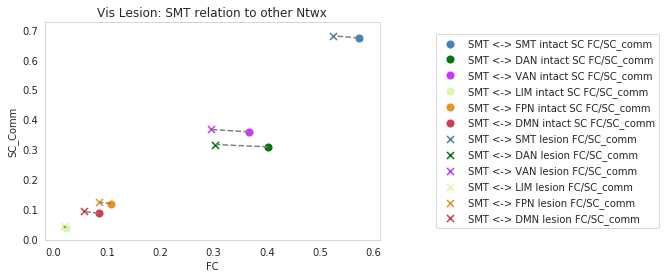

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -0.15148105709681314
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -0.07770938103359568
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -0.11263946792306505
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  -1.4162023408740665
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  -0.15767025915623217
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  -0.22371120081305568


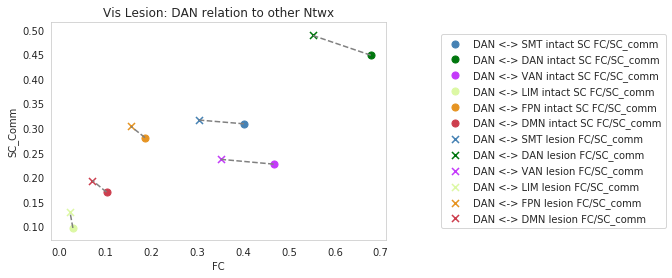

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -0.07770938103359623
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -0.31769208840240976
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -0.08429258261759727
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  -5.124564287522336
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  -0.7445705441664986
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  -0.7734119708717819


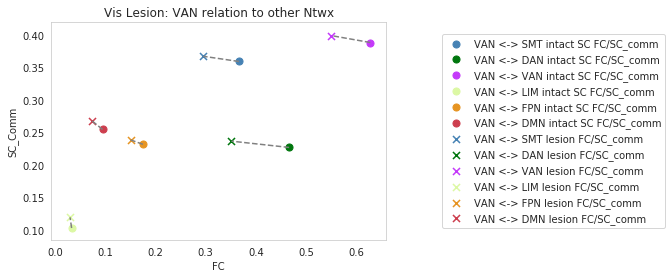

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -0.11263946792306279
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -0.08429258261759602
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -0.13685533901947644
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  -5.369163395766898
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  -0.27488718242342414
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  -0.6310099040878975


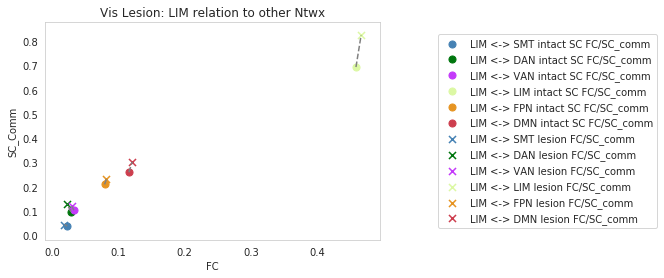

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -1.4162023408740665
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -5.12456428752234
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -5.369163395766898
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  16.908612009492895
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  7.769300646577523
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  8.663810665110482


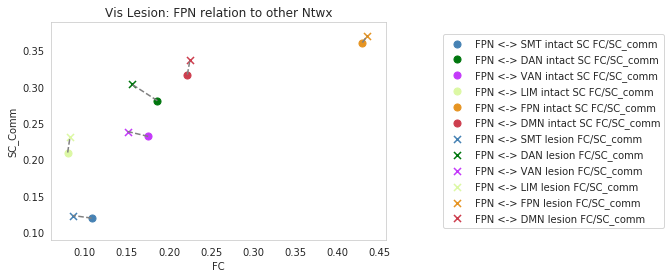

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -0.15767025915623156
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -0.7445705441664986
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -0.27488718242341964
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  7.769300646577523
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  1.5677797934386029
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  6.678073958574186


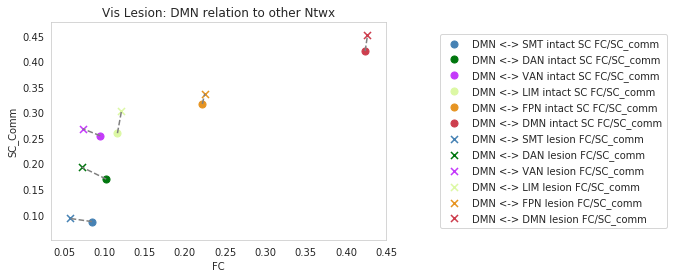

Slope b/w INTACT & VIS lesion FC/SC_comm for SMT =  -0.22371120081305582
Slope b/w INTACT & VIS lesion FC/SC_comm for DAN =  -0.7734119708717798
Slope b/w INTACT & VIS lesion FC/SC_comm for VAN =  -0.6310099040878923
Slope b/w INTACT & VIS lesion FC/SC_comm for LIM =  8.663810665110507
Slope b/w INTACT & VIS lesion FC/SC_comm for FPN =  6.678073958574062
Slope b/w INTACT & VIS lesion FC/SC_comm for DMN =  10.650253785743626


In [620]:
for i in range(7): 
    
    if i !=0:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_vis_lesion_outer_to_other_ntwx[i]

        y_coords_1 = vis_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the first value from each list
        x_coords = x_coords[1:]
        y_coords = y_coords[1:]
        x_coords_1 = x_coords_1[1:]
        y_coords_1 = y_coords_1[1:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[1:]
        Ntwx_labels2 = Ntwx_labels[1:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('Vis Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & VIS lesion FC/SC_comm for {0} = ".format(Ntwx_labels2[j]), slope)

### SMT Lesion

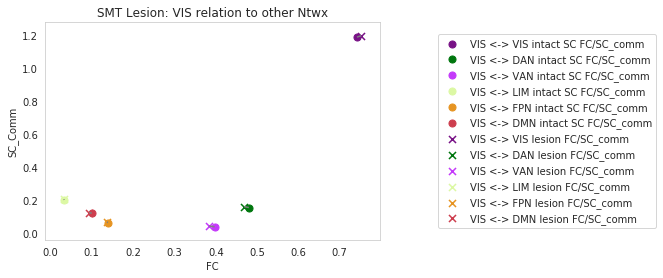

Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> VIS =  0.8018033532499568
Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> DAN =  -0.5050594833486132
Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> VAN =  -0.3955027387729717
Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> LIM =  -5.591096299118464
Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> FPN =  -1.1097075541410757
Slope b/w INTACT & SMT lesion FC/SC_comm for VIS <-> DMN =  -0.6366458676050646


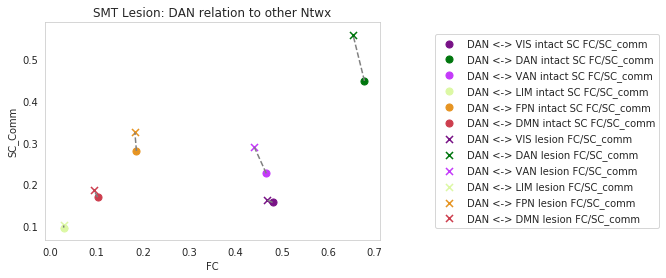

Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> VIS =  -0.5050594833486179
Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> DAN =  -4.47090058221222
Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> VAN =  -2.4455292616369717
Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> LIM =  65.72060064595459
Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> FPN =  -13.041506047658993
Slope b/w INTACT & SMT lesion FC/SC_comm for DAN <-> DMN =  -2.188326186469597


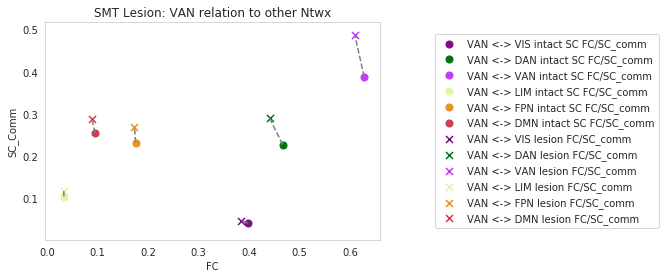

Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> VIS =  -0.3955027387729717
Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> DAN =  -2.4455292616369757
Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> VAN =  -5.410907213437933
Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> LIM =  -26.867579045374097
Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> FPN =  -15.766833029283298
Slope b/w INTACT & SMT lesion FC/SC_comm for VAN <-> DMN =  -5.258604757616578


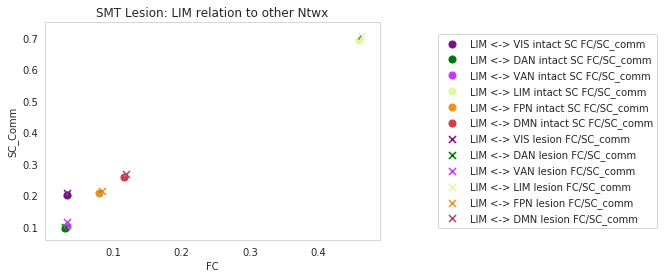

Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> VIS =  -5.591096299118631
Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> DAN =  65.72060064595148
Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> VAN =  -26.867579045374097
Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> LIM =  3.4205949440940286
Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> FPN =  1.6485634940283578
Slope b/w INTACT & SMT lesion FC/SC_comm for LIM <-> DMN =  3.139770679149244


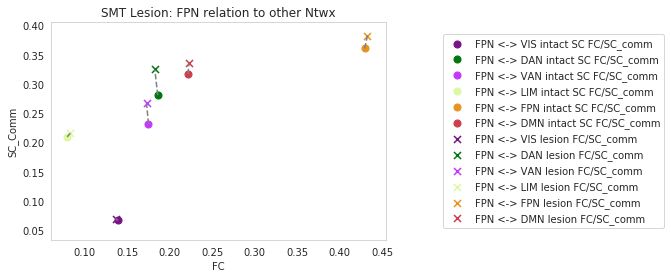

Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> VIS =  -1.109707554141063
Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> DAN =  -13.0415060476591
Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> VAN =  -15.766833029283106
Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> LIM =  1.6485634940283638
Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> FPN =  6.677433292994807
Slope b/w INTACT & SMT lesion FC/SC_comm for FPN <-> DMN =  15.096569552553452


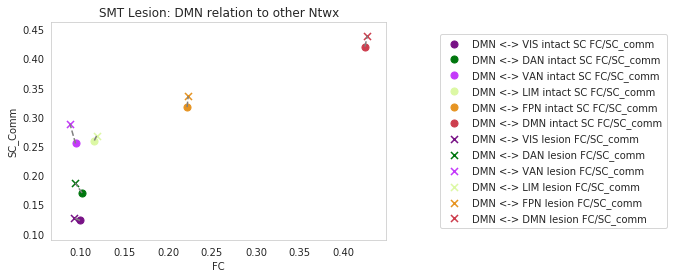

Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> VIS =  -0.6366458676050717
Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> DAN =  -2.1883261864695864
Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> VAN =  -5.258604757616578
Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> LIM =  3.139770679149284
Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> FPN =  15.096569552553452
Slope b/w INTACT & SMT lesion FC/SC_comm for DMN <-> DMN =  6.638243043891386


In [621]:
for i in range(7): 
    
    if i !=1:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_smt_lesion_outer_to_other_ntwx[i]

        y_coords_1 = smt_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 2nd value from each list
        x_coords = x_coords[:1] + x_coords[2:]
        y_coords = y_coords[:1] + y_coords[2:]
        x_coords_1 = x_coords_1[:1] + x_coords_1[2:]
        y_coords_1 = y_coords_1[:1] + y_coords_1[2:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[:1] + ntwx_hex_codes[2:]
        Ntwx_labels2 = Ntwx_labels[:1] + Ntwx_labels[2:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('SMT Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & SMT lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)

### DAN Lesion

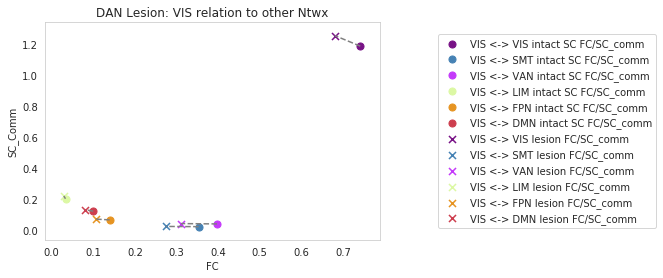

Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> VIS =  -1.1143545190201505
Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> SMT =  -0.01892142419879207
Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> VAN =  -0.025500508607795357
Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> LIM =  -4.318388162857594
Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> FPN =  -0.14969434782976562
Slope b/w INTACT & DAN lesion FC/SC_comm for VIS <-> DMN =  -0.5036629152417662


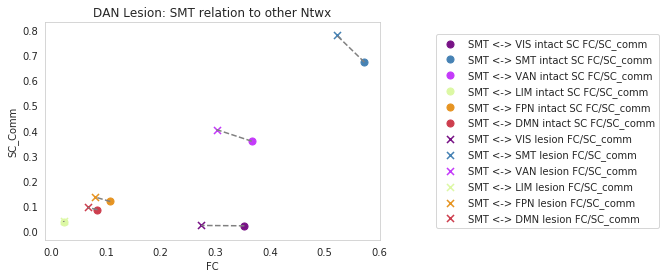

Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> VIS =  -0.0189214241987922
Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> SMT =  -2.113021387257455
Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> VAN =  -0.7151107467377826
Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> LIM =  -13.244212470496633
Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> FPN =  -0.6320546853569761
Slope b/w INTACT & DAN lesion FC/SC_comm for SMT <-> DMN =  -0.5014395807089838


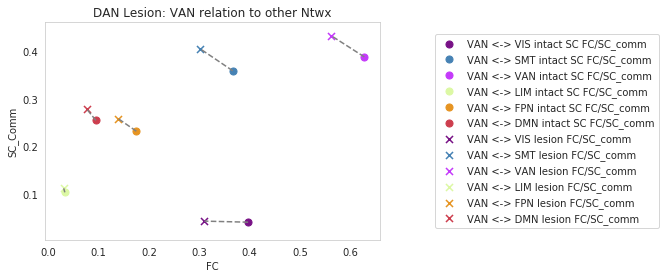

Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> VIS =  -0.025500508607795357
Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> SMT =  -0.7151107467377817
Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> VAN =  -0.6784211490389045
Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> LIM =  -3.671015239351293
Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> FPN =  -0.7334823025140967
Slope b/w INTACT & DAN lesion FC/SC_comm for VAN <-> DMN =  -1.3115053480911347


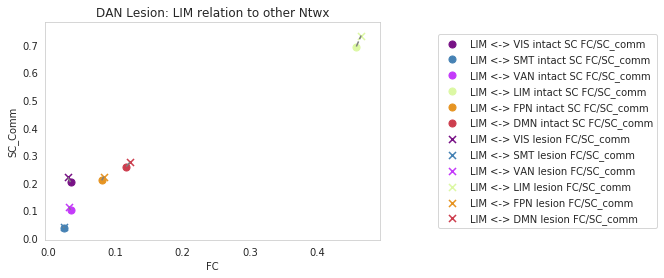

Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> VIS =  -4.318388162857594
Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> SMT =  -13.244212470496633
Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> VAN =  -3.671015239351293
Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> LIM =  5.568079326331568
Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> FPN =  3.995278829439311
Slope b/w INTACT & DAN lesion FC/SC_comm for LIM <-> DMN =  2.9474567861268497


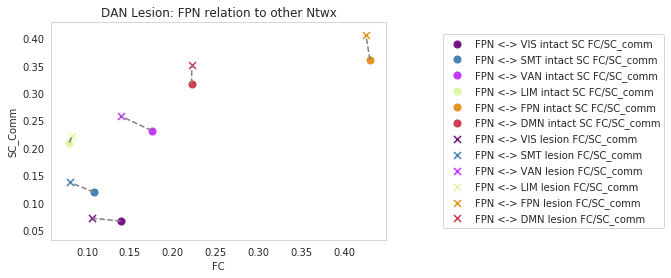

Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> VIS =  -0.14969434782976537
Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> SMT =  -0.6320546853569761
Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> VAN =  -0.7334823025140925
Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> LIM =  3.995278829439311
Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> FPN =  -9.450774780314482
Slope b/w INTACT & DAN lesion FC/SC_comm for FPN <-> DMN =  82.85875822869488


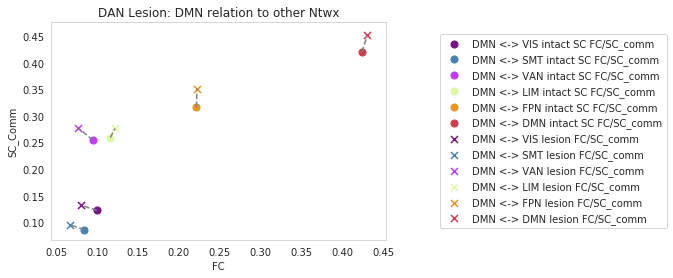

Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> VIS =  -0.5036629152417669
Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> SMT =  -0.5014395807089819
Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> VAN =  -1.3115053480911347
Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> LIM =  2.947456786126857
Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> FPN =  82.85875822869474
Slope b/w INTACT & DAN lesion FC/SC_comm for DMN <-> DMN =  4.401051088676606


In [622]:
for i in range(7): 
    
    if i !=2:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_dan_lesion_outer_to_other_ntwx[i]

        y_coords_1 = dan_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 3rd value from each list
        x_coords = x_coords[:2] + x_coords[3:]
        y_coords = y_coords[:2] + y_coords[3:]
        x_coords_1 = x_coords_1[:2] + x_coords_1[3:]
        y_coords_1 = y_coords_1[:2] + y_coords_1[3:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[:2] + ntwx_hex_codes[3:]
        Ntwx_labels2 = Ntwx_labels[:2] + Ntwx_labels[3:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('DAN Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & DAN lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)

### VAN Lesion

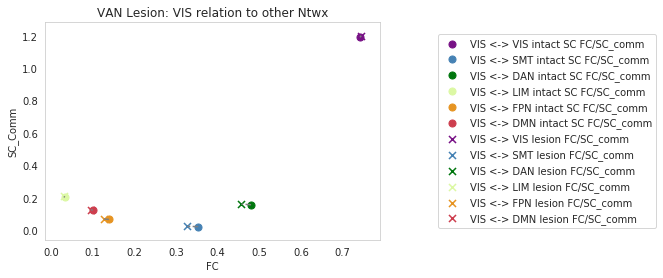

Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> VIS =  3.5551395751735635
Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> SMT =  -0.03133399090132867
Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> DAN =  -0.18027099702904686
Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> LIM =  -2.0970010615441255
Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> FPN =  -0.24400883583887042
Slope b/w INTACT & VAN lesion FC/SC_comm for VIS <-> DMN =  -1.3251402549849578


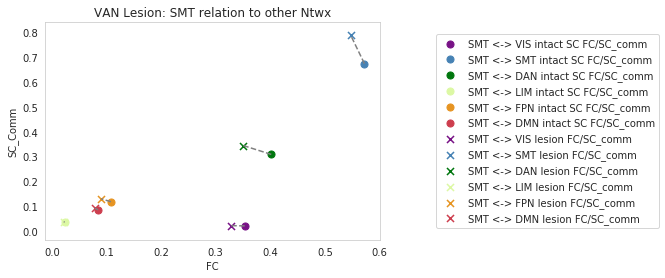

Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> VIS =  -0.03133399090132827
Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> SMT =  -4.5085262088221505
Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> DAN =  -0.6906828130433983
Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> LIM =  -0.48494774586779577
Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> FPN =  -0.6518033993972246
Slope b/w INTACT & VAN lesion FC/SC_comm for SMT <-> DMN =  -1.1619325748302514


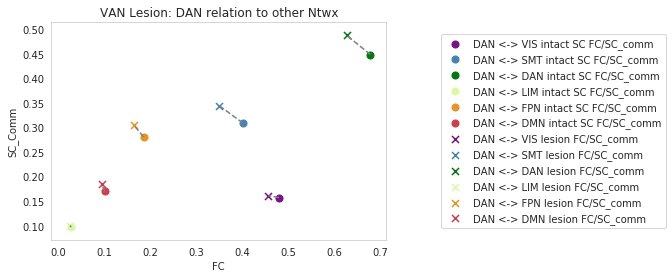

Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> VIS =  -0.18027099702904806
Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> SMT =  -0.6906828130433994
Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> DAN =  -0.7558001211404726
Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> LIM =  -1.4480923928273142
Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> FPN =  -1.1307967531076581
Slope b/w INTACT & VAN lesion FC/SC_comm for DAN <-> DMN =  -1.9446422776265828


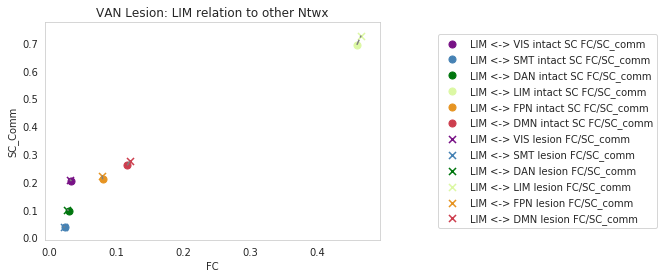

Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> VIS =  -2.097001061544123
Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> SMT =  -0.48494774586780054
Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> DAN =  -1.4480923928273146
Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> LIM =  5.2462999195330635
Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> FPN =  -20.836411232059195
Slope b/w INTACT & VAN lesion FC/SC_comm for LIM <-> DMN =  4.0052343314225185


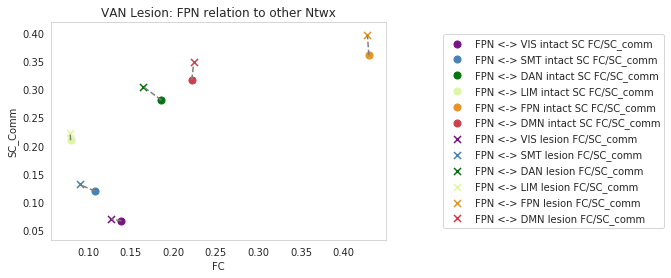

Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> VIS =  -0.2440088358388693
Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> SMT =  -0.6518033993972261
Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> DAN =  -1.1307967531076581
Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> LIM =  -20.836411232059238
Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> FPN =  -20.449919129969807
Slope b/w INTACT & VAN lesion FC/SC_comm for FPN <-> DMN =  13.494118685855053


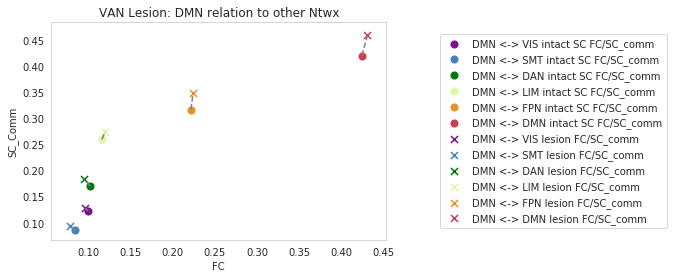

Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> VIS =  -1.3251402549849602
Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> SMT =  -1.1619325748302471
Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> DAN =  -1.9446422776265717
Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> LIM =  4.005234331422534
Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> FPN =  13.494118685855053
Slope b/w INTACT & VAN lesion FC/SC_comm for DMN <-> DMN =  5.650494081748114


In [623]:
for i in range(7): 
    
    if i !=3:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_van_lesion_outer_to_other_ntwx[i]

        y_coords_1 = van_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 3rd value from each list
        x_coords = x_coords[:3] + x_coords[4:]
        y_coords = y_coords[:3] + y_coords[4:]
        x_coords_1 = x_coords_1[:3] + x_coords_1[4:]
        y_coords_1 = y_coords_1[:3] + y_coords_1[4:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[:3] + ntwx_hex_codes[4:]
        Ntwx_labels2 = Ntwx_labels[:3] + Ntwx_labels[4:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('VAN Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & VAN lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)

### LIM Lesion

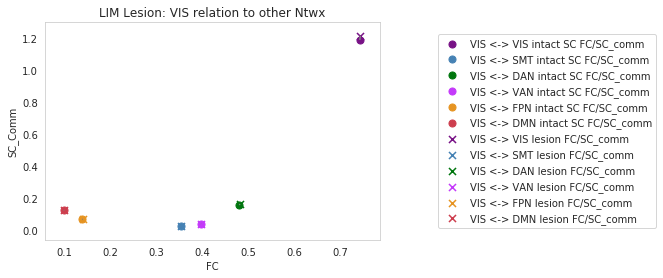

Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> VIS =  25.10149858074922
Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> SMT =  0.9449273198124707
Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> DAN =  3.254389110138638
Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> VAN =  -1.2595433367874243
Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> FPN =  0.531034052009883
Slope b/w INTACT & LIM lesion FC/SC_comm for VIS <-> DMN =  -6.856112658521589


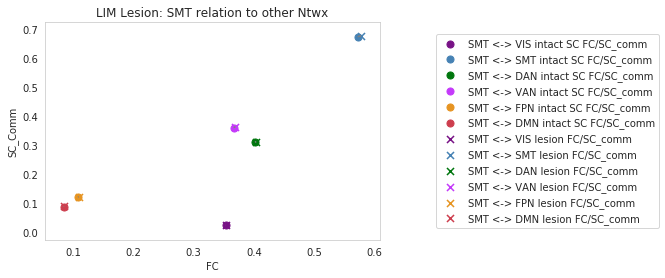

Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> VIS =  0.9449273198119609
Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> SMT =  0.5904924614447005
Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> DAN =  0.7484693330437316
Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> VAN =  1.2658813913641631
Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> FPN =  1.3708938209797046
Slope b/w INTACT & LIM lesion FC/SC_comm for SMT <-> DMN =  -5.599636558507313


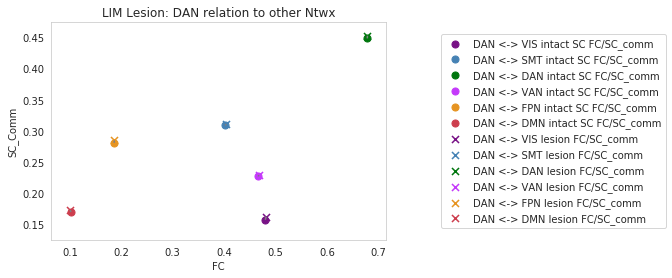

Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> VIS =  3.2543891101386553
Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> SMT =  0.7484693330437807
Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> DAN =  16.24446787884297
Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> VAN =  2.479370594092732
Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> FPN =  13.686456311280113
Slope b/w INTACT & LIM lesion FC/SC_comm for DAN <-> DMN =  -1.6927394966298819


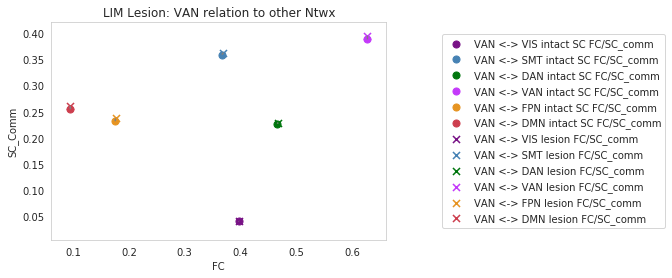

Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> VIS =  -1.2595433367877023
Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> SMT =  1.2658813913641442
Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> DAN =  2.4793705940920616
Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> VAN =  -494.3499918474974
Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> FPN =  9.240847418393452
Slope b/w INTACT & LIM lesion FC/SC_comm for VAN <-> DMN =  -11.502248271838566


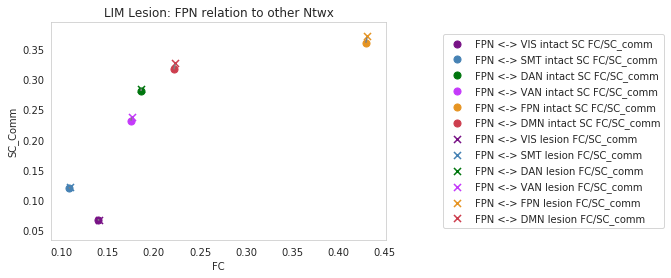

Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> VIS =  0.5310340520099016
Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> SMT =  1.3708938209797046
Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> DAN =  13.686456311280113
Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> VAN =  9.240847418393258
Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> FPN =  6.5583614114620215
Slope b/w INTACT & LIM lesion FC/SC_comm for FPN <-> DMN =  6.197181435332723


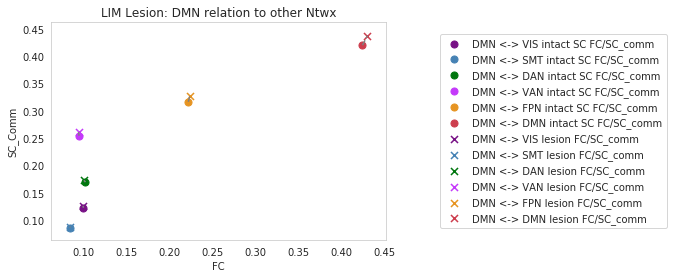

Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> VIS =  -6.856112658521974
Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> SMT =  -5.599636558507313
Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> DAN =  -1.692739496629838
Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> VAN =  -11.502248271838566
Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> FPN =  6.197181435332723
Slope b/w INTACT & LIM lesion FC/SC_comm for DMN <-> DMN =  3.028426125630113


In [624]:
for i in range(7): 
    
    if i !=4:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_lim_lesion_outer_to_other_ntwx[i]

        y_coords_1 = lim_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 4th value from each list
        x_coords = x_coords[:4] + x_coords[5:]
        y_coords = y_coords[:4] + y_coords[5:]
        x_coords_1 = x_coords_1[:4] + x_coords_1[5:]
        y_coords_1 = y_coords_1[:4] + y_coords_1[5:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[:4] + ntwx_hex_codes[5:]
        Ntwx_labels2 = Ntwx_labels[:4] + Ntwx_labels[5:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('LIM Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & LIM lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)

### FPN Lesion

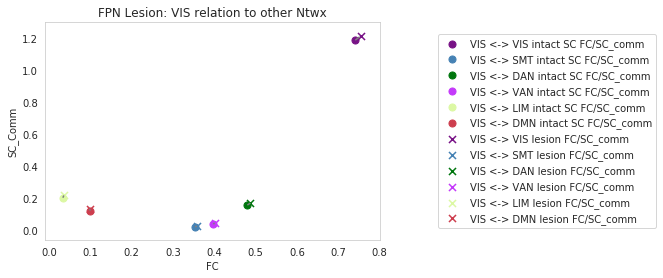

Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> VIS =  1.9567809475684361
Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> SMT =  0.18092302073009414
Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> DAN =  1.7298254273897284
Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> VAN =  0.637899758906819
Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> LIM =  5.916849836711469
Slope b/w INTACT & FPN lesion FC/SC_comm for VIS <-> DMN =  -4.660909377669255


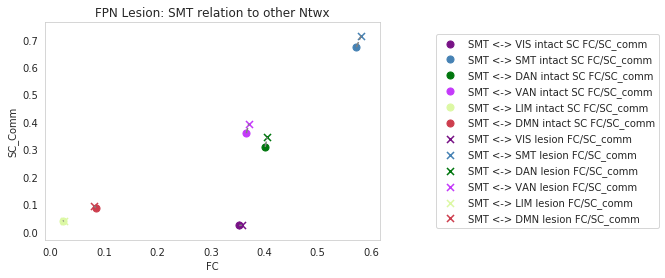

Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> VIS =  0.18092302073009342
Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> SMT =  4.822993464133745
Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> DAN =  9.766803480389433
Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> VAN =  7.880456165259633
Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> LIM =  1.7645471280443417
Slope b/w INTACT & FPN lesion FC/SC_comm for SMT <-> DMN =  -2.979188651873418


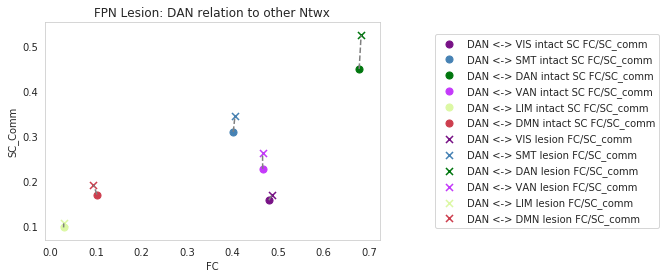

Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> VIS =  1.729825427389736
Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> SMT =  9.766803480389447
Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> DAN =  17.62247046092766
Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> VAN =  -93.4272909044479
Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> LIM =  41.61084618946955
Slope b/w INTACT & FPN lesion FC/SC_comm for DAN <-> DMN =  -2.8447977179565114


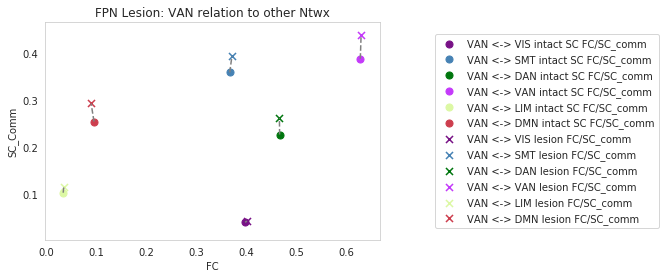

Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> VIS =  0.6378997589068469
Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> SMT =  7.880456165259621
Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> DAN =  -93.42729090444769
Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> VAN =  32.11688684934267
Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> LIM =  10.657126393237577
Slope b/w INTACT & FPN lesion FC/SC_comm for VAN <-> DMN =  -6.696369097212906


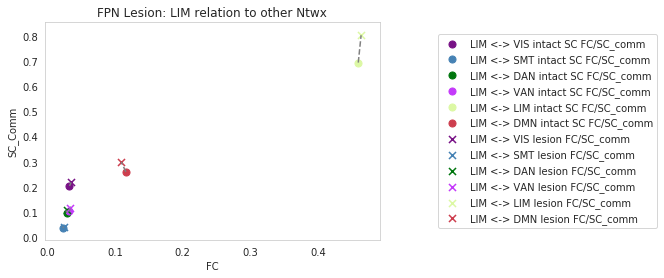

Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> VIS =  5.916849836711452
Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> SMT =  1.7645471280443417
Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> DAN =  41.61084618946875
Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> VAN =  10.657126393237595
Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> LIM =  26.054492784268525
Slope b/w INTACT & FPN lesion FC/SC_comm for LIM <-> DMN =  -5.809338057465421


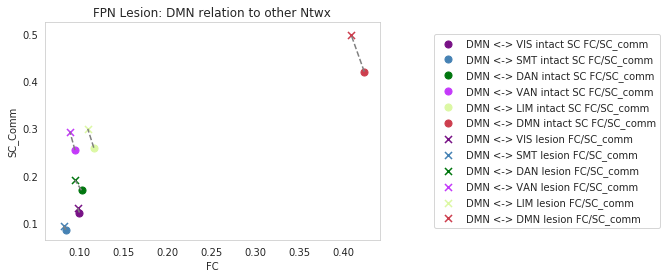

Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> VIS =  -4.660909377669285
Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> SMT =  -2.979188651873418
Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> DAN =  -2.844797717956499
Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> VAN =  -6.6963690972129
Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> LIM =  -5.80933805746541
Slope b/w INTACT & FPN lesion FC/SC_comm for DMN <-> DMN =  -5.203988368027723


In [626]:
for i in range(7): 
    
    if i !=5:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_fpn_lesion_outer_to_other_ntwx[i]

        y_coords_1 = fpn_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 5th value from each list
        x_coords = x_coords[:5] + x_coords[6:]
        y_coords = y_coords[:5] + y_coords[6:]
        x_coords_1 = x_coords_1[:5] + x_coords_1[6:]
        y_coords_1 = y_coords_1[:5] + y_coords_1[6:]
        
        ntwx_hex_codes2 = ntwx_hex_codes[:5] + ntwx_hex_codes[6:]
        Ntwx_labels2 = Ntwx_labels[:5] + Ntwx_labels[6:]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('FPN Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & FPN lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)

### DMN Lesion

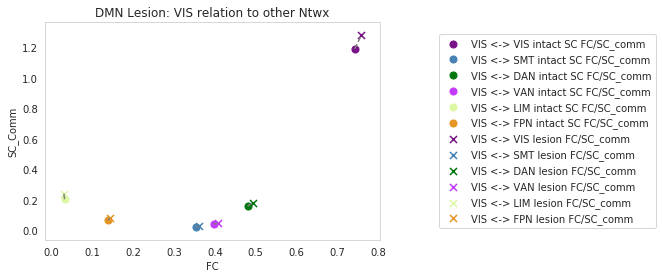

Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> VIS =  5.492113177011007
Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> SMT =  0.23027387303160352
Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> DAN =  1.9185839876917585
Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> VAN =  0.47833446381122036
Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> LIM =  -21.016072319188027
Slope b/w INTACT & DMN lesion FC/SC_comm for VIS <-> FPN =  2.7002328219426506


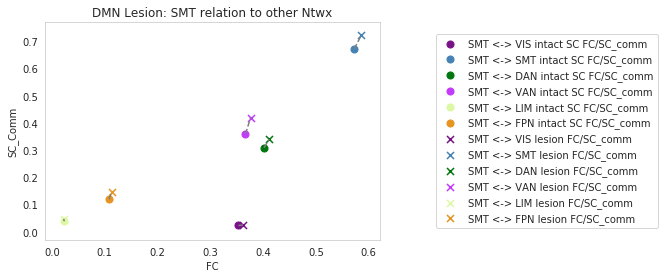

Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> VIS =  0.23027387303160352
Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> SMT =  3.751305908281326
Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> DAN =  3.2908755036861796
Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> VAN =  6.326311353958206
Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> LIM =  -8.311065812561175
Slope b/w INTACT & DMN lesion FC/SC_comm for SMT <-> FPN =  5.267959159729558


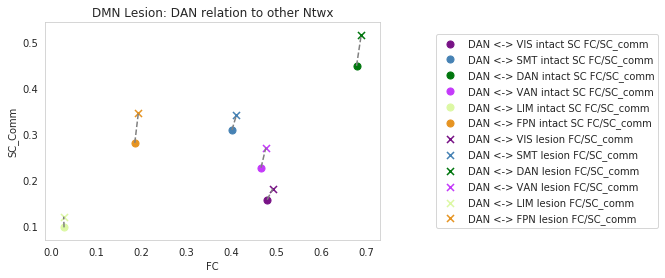

Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> VIS =  1.9185839876917608
Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> SMT =  3.2908755036861854
Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> DAN =  6.531085031691472
Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> VAN =  4.127888294652057
Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> LIM =  -32.559392147976766
Slope b/w INTACT & DMN lesion FC/SC_comm for DAN <-> FPN =  8.283578113672693


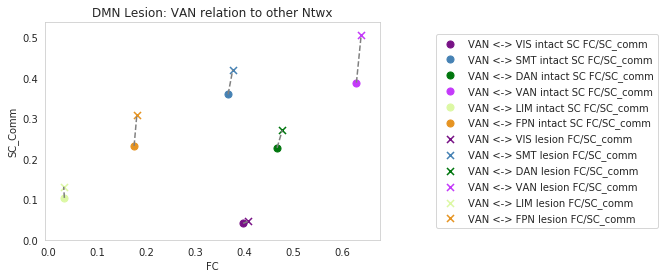

Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> VIS =  0.4783344638112218
Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> SMT =  6.3263113539582
Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> DAN =  4.127888294652098
Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> VAN =  12.181983855939041
Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> LIM =  -20.021232570348957
Slope b/w INTACT & DMN lesion FC/SC_comm for VAN <-> FPN =  13.803023974104244


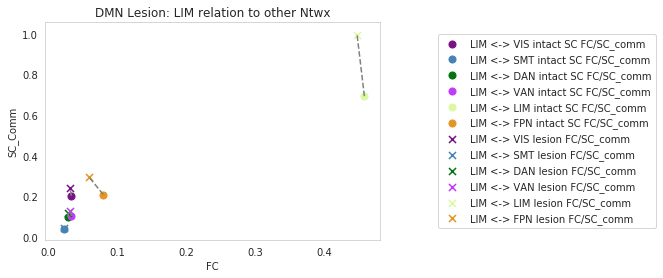

Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> VIS =  -21.01607231918798
Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> SMT =  -8.311065812561182
Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> DAN =  -32.55939214797659
Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> VAN =  -20.021232570348957
Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> LIM =  -28.45668572768107
Slope b/w INTACT & DMN lesion FC/SC_comm for LIM <-> FPN =  -4.141706136834058


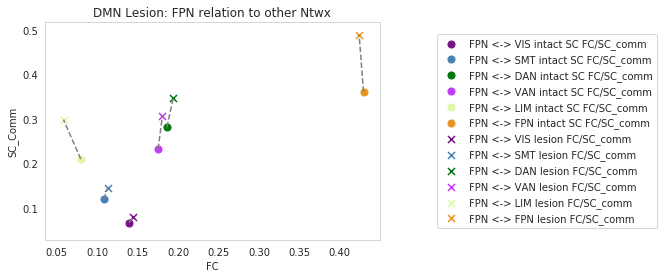

Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> VIS =  2.700232821942682
Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> SMT =  5.267959159729558
Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> DAN =  8.283578113672672
Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> VAN =  13.803023974104272
Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> LIM =  -4.141706136834058
Slope b/w INTACT & DMN lesion FC/SC_comm for FPN <-> FPN =  -23.396507738623882


In [627]:
for i in range(7): 
    
    if i !=6:
        
        x_coords = og_whobpyt_outer_to_other_ntwx[i]

        y_coords = intact_sc_between_other_ntwx[i]

        x_coords_1 = fc_dmn_lesion_outer_to_other_ntwx[i]

        y_coords_1 = dmn_lesion_between_other_ntwx[i]

        sns.set_style('whitegrid')
        
        # Remove the 5th value from each list
        x_coords = x_coords[:6] 
        y_coords = y_coords[:6] 
        x_coords_1 = x_coords_1[:6] 
        y_coords_1 = y_coords_1[:6] 
        
        ntwx_hex_codes2 = ntwx_hex_codes[:6]
        Ntwx_labels2 = Ntwx_labels[:6]
        
        y_coords = [value*10 for value in y_coords] # 'x10' for clarity
        y_coords_1 = [value*10 for value in y_coords_1] # 'x10' for clarity

        # Calculate the slope of each line and store it in a list
        slopes = []
        for (x1, y1, x2, y2) in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            slope = (y2 - y1) / (x2 - x1)
            slopes.append(slope)
            
        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1
#         plt.scatter(x_coords, y_coords, label='intact SC FC/intact SC SC_comm', marker='o', color=ntwx_hex_codes2[i], s=50)
#         plt.scatter(x_coords_1, y_coords_1, label='{0}_lesion FC/{0}_lesion SC_comm', marker='x', color=ntwx_hex_codes2[i], s=50)

        # Create a scatter plot for x_coords/y_coords and x_coords_1/y_coords_1 with different colors
        for k, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.scatter(x, y, label='{0} <-> {1} intact SC FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='o', color=ntwx_hex_codes2[k], s=50)
        for k, (x, y) in enumerate(zip(x_coords_1, y_coords_1)):
            plt.scatter(x, y, label='{0} <-> {1} lesion FC/SC_comm'.format(Ntwx_labels[i],Ntwx_labels2[k]), marker='x', color=ntwx_hex_codes2[k], s=50)

        # Draw lines between the points
        for x1, y1, x2, y2 in zip(x_coords, y_coords, x_coords_1, y_coords_1):
            plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

        # Set labels and legend
        plt.xlabel('FC')
        plt.ylabel('SC_Comm')
        plt.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

        # Set plot title
        plt.title('DMN Lesion: {0} relation to other Ntwx'.format(Ntwx_labels[i]))

        # Show the plot
        plt.grid(False)
        plt.show()

        # Display the slopes
        for j, slope in enumerate(slopes):
            print("Slope b/w INTACT & DMN lesion FC/SC_comm for {0} <-> {1} = ".format(Ntwx_labels[i], Ntwx_labels2[j]), slope)